# VGG2D

In [1]:
# Imports
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf


2024-04-04 10:32:25.168748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Import Data

In [2]:
# # Mount google drive to load data
# from google.colab import drive
# drive.mount('/content/drive')

# # Get reference to drive
# image_dir = 'drive/MyDrive/ENEL645/data/'


In [3]:
# recommended from TALC documentation
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load dataset
image_dir = '/home/jennifer.bushey/enel645/data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    labels='inferred'
)

dataset_path = os.listdir(image_dir)

class_names = dataset.class_names
print("Class names:", class_names)

Found 3096 files belonging to 4 classes.
Class names: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


2024-04-04 10:32:36.974677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-04 10:32:37.153263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.58GiB deviceMemoryBandwidth: 298.08GiB/s
2024-04-04 10:32:37.153360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-04 10:32:37.159114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-04 10:32:37.159257: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-04-04 10:32:37.163138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2024-0

In [4]:
def extract_images_to_dataframe(dataset_path, image_dir):
    '''
    Extracts images and their class labels from a dataset and stores them in a pandas dataframe

    Parameters:
    - dataset_path: The path to the dataset stored on google drive or local machine
    - image_dir: The directory where the images are stored.

    Returns:
    - A pandas dataframe containing the image file paths and their corresponding label.
    '''
    data = []

    for item in dataset_path:
        if item.startswith('.'):
            continue  # Skip directories starting with a dot (e.g., .DS_Store)

        all_classes = os.listdir(image_dir + '/' + item)

        for obj in all_classes:
            # if (random.randint(1,100) > 15): #only select 5% of data for prototyping
            #   continue
            data.append((item, str(image_dir + '/' + item) + '/' + obj))

    df = pd.DataFrame(data=data, columns=['label', 'img_path'])
    return df

In [5]:
df = extract_images_to_dataframe(dataset_path, image_dir)

print("Total number of images in the dataset: ", len(df), "\n")

label_count = df['label'].value_counts()
print(label_count)

Total number of images in the dataset:  3096 

meningioma_tumor    913
glioma_tumor        901
pituitary_tumor     844
normal              438
Name: label, dtype: int64


### Image Resizing

In [6]:
img_size = 224

images = []
labels = []
for img_path in df['img_path']:
    directory, filename = os.path.split(img_path)
    # print(directory, filename)
    img = cv2.imread(directory + '/' + filename)
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(df[df['img_path'] == img_path]['label'].values[0])

# print(df['img_path'].shape)
# print(len(images), len(labels))

### Processing Labels (OHE)

In [7]:
# Encoding
y = df['label'].values
# print(y, '\n')

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
type(y)

numpy.ndarray

In [8]:
y = y.reshape(-1, 1)

ct = ColumnTransformer(
    [('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()



### Train-Val-Test Split

In [9]:
images, Y = shuffle(images, Y, random_state=1)

images_np = np.array(images)
Y_np = np.array(Y)

train_x, test_x, train_y, test_y = train_test_split(
    images_np, Y_np, test_size=0.15, random_state=420)

train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.15, random_state=420)

# inpect the shape of the training and testing.
print("Training X:", train_x.shape)
print("Training Y:", train_y.shape)
print("")
print("Validation X:", val_x.shape)
print("Validation Y:", val_y.shape)
print("")
print("Testing X:", test_x.shape)
print("Testing Y:", test_y.shape)

Training X: (2236, 224, 224, 3)
Training Y: (2236, 4)

Validation X: (395, 224, 224, 3)
Validation Y: (395, 4)

Testing X: (465, 224, 224, 3)
Testing Y: (465, 4)


### Class Weights for imbalanced classes

In [10]:
# Get Class Weights for Imbalanced Classes
unique_classes, class_counts = np.unique(train_y, axis=0, return_counts=True)
unique_classes = y_labelencoder.inverse_transform(
    np.argmax(unique_classes, axis=1))
print(unique_classes)

class_weights = {}
total_samples = np.sum(class_counts)
for i in range(3, -1, -1):
    class_weights[i] = 1 - class_counts[i]/total_samples
print(class_weights)

print("Class weights:", class_weights)

['pituitary_tumor' 'normal' 'meningioma_tumor' 'glioma_tumor']
{3: 0.7008050089445439, 2: 0.7110912343470484, 1: 0.8555456171735242, 0: 0.7325581395348837}
Class weights: {3: 0.7008050089445439, 2: 0.7110912343470484, 1: 0.8555456171735242, 0: 0.7325581395348837}


## Simple CNN Model

Structure based on VGG from this article: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0258214



In [11]:
# Defining a simple CNN model (VGG2D)
lr = 1e-3
dropout = 0.5
filters = 32
l2_reg = 0.01

model_input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
l1 = tf.keras.layers.Conv2D(
    filters, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(model_input)
l1_bn = tf.keras.layers.BatchNormalization()(l1)
l1_act = tf.keras.layers.Activation('relu')(l1_bn)

l2 = tf.keras.layers.Conv2D(
    filters*2, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(l1_act)
l2_bn = tf.keras.layers.BatchNormalization()(l2)
l2_act = tf.keras.layers.Activation('relu')(l2_bn)

l3 = tf.keras.layers.MaxPool2D((2, 2))(l2_act)
l3_drop = tf.keras.layers.Dropout(dropout)(l3)

l4 = tf.keras.layers.Conv2D(
    filters*2*2, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(l3_drop)
l4_bn = tf.keras.layers.BatchNormalization()(l4)
l4_act = tf.keras.layers.Activation('relu')(l4_bn)

l5 = tf.keras.layers.Conv2D(
    filters*2*2*2, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(l4_act)
l5_bn = tf.keras.layers.BatchNormalization()(l5)
l5_act = tf.keras.layers.Activation('relu')(l5_bn)

l6 = tf.keras.layers.MaxPool2D((2, 2))(l5_act)
l6_drop = tf.keras.layers.Dropout(dropout)(l6)

flat = tf.keras.layers.Flatten()(l6_drop)

out = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(
    flat)  # 4 classes in output

model = tf.keras.models.Model(
    inputs=model_input, outputs=out, name="VGG-2D")
print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy", metrics=["accuracy"])

Model: "VGG-2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0    

In [12]:
# Callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

checkpoint_filepath = f'{image_dir}checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', # Monitor validation loss
    mode='min', # Save the model when validation accuracy improves
    save_best_only=True, # Save only the best model
)



def scheduler(epoch, lr):
    # Learning rate schedule
    if epoch % 10 == 0 and epoch != 0:
        lr = lr/2
    return lr

In [13]:
# Training Loop
epochs = 200
batch_size = 4
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

hist = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs,
                 verbose=2, callbacks=[early_stopping, lr_schedule, checkpoint],
                 class_weight=class_weights, validation_data=(val_x, val_y), shuffle=True)

2024-04-04 10:32:57.470599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200


2024-04-04 10:32:58.523934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-04 10:32:58.957064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-04-04 10:33:00.883000: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-04-04 10:33:00.994489: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


559/559 - 52s - loss: 62.0534 - accuracy: 0.4629 - val_loss: 39.0437 - val_accuracy: 0.5646


2024-04-04 10:33:50.664939: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jennifer.bushey/enel645/datacheckpoint/assets
Epoch 2/200
559/559 - 23s - loss: 14.6503 - accuracy: 0.6140 - val_loss: 12.9590 - val_accuracy: 0.6937
INFO:tensorflow:Assets written to: /home/jennifer.bushey/enel645/datacheckpoint/assets
Epoch 3/200
559/559 - 23s - loss: 9.5264 - accuracy: 0.6221 - val_loss: 10.2369 - val_accuracy: 0.6152
INFO:tensorflow:Assets written to: /home/jennifer.bushey/enel645/datacheckpoint/assets
Epoch 4/200
559/559 - 23s - loss: 13.9581 - accuracy: 0.5774 - val_loss: 40.2408 - val_accuracy: 0.4886
Epoch 5/200
559/559 - 23s - loss: 13.6863 - accuracy: 0.6199 - val_loss: 11.2654 - val_accuracy: 0.6962
Epoch 6/200
559/559 - 23s - loss: 8.8873 - accuracy: 0.6807 - val_loss: 24.1773 - val_accuracy: 0.3873
Epoch 7/200
559/559 - 23s - loss: 16.2134 - accuracy: 0.5975 - val_loss: 15.2477 - val_accuracy: 0.5722
Epoch 8/200
559/559 - 23s - loss: 9.1257 - accuracy: 0.7518 - val_loss: 7.2356 - val_accuracy: 0.5418
INFO:tensorflow

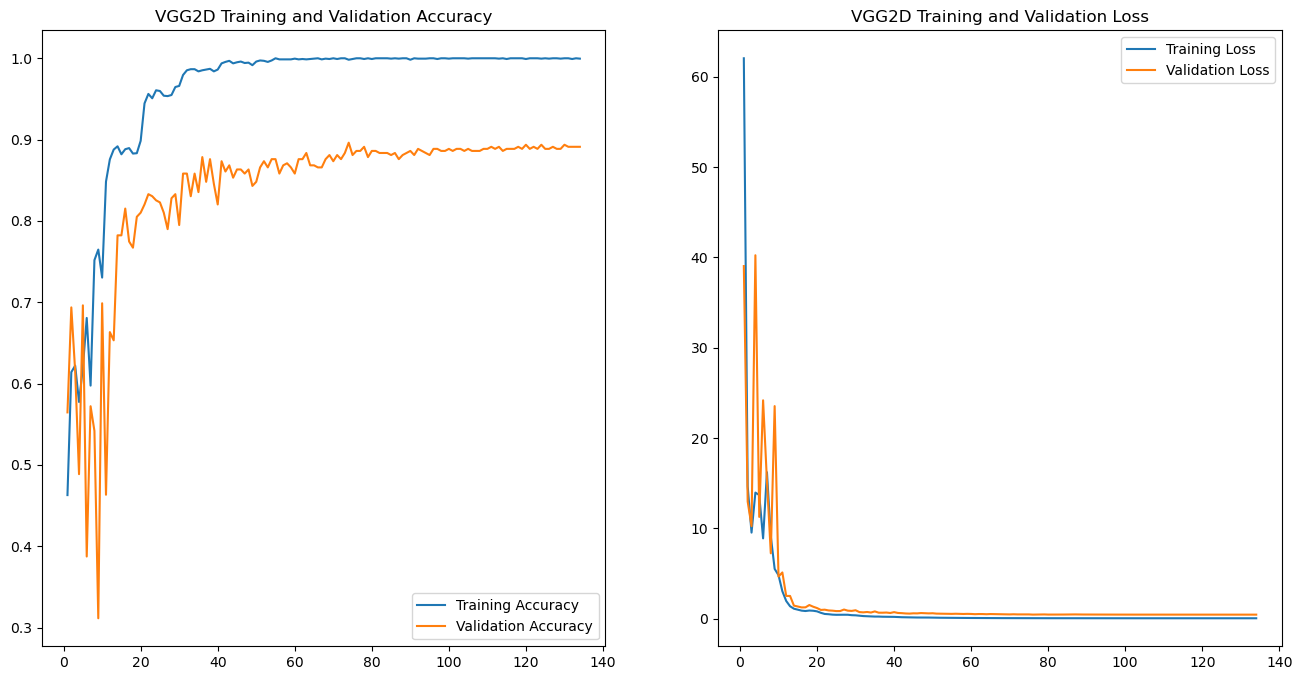

In [14]:
# Monitoring Plot

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(1, len(hist.history['accuracy']) + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('VGG2D Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('VGG2D Training and Validation Loss')
plt.savefig('hist.png')
plt.show()

# Load the best model for evaluation
best_model = tf.keras.models.load_model(checkpoint_filepath)

In [15]:
# Evaluate Testing Accuracy
preds = best_model.evaluate(test_x, test_y, verbose=0)
# print("Loss = " + str(preds[0]))
# print("Test Accuracy = " + str(preds[1]))
print(f"Test Loss: {preds[0]}, Test Accuracy: {preds[1]}")

# Prediction
y_pred = best_model.predict(test_x, verbose=0)

Test Loss: 0.43338486552238464, Test Accuracy: 0.8645161390304565


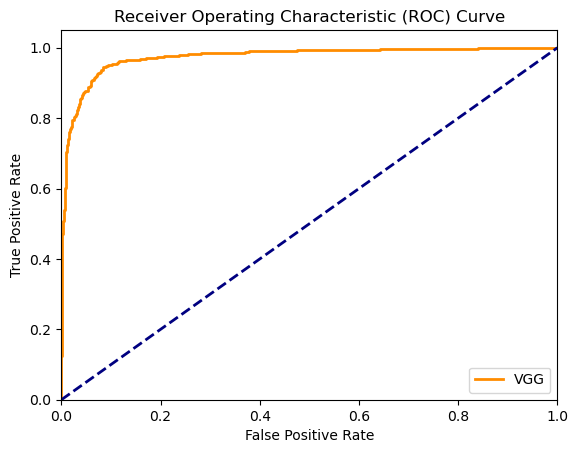

AUC Score: 0.9740748448760936


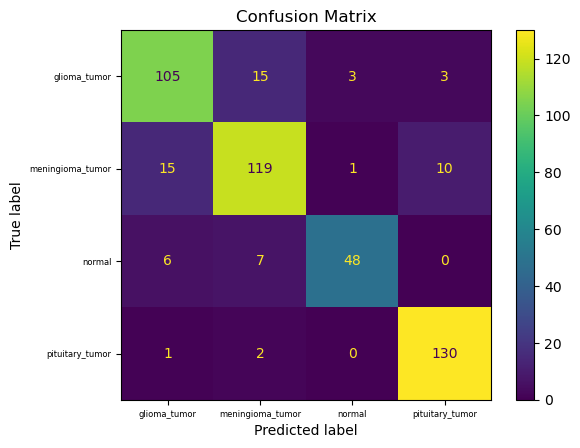

In [16]:
# ROC curve
fpr, tpr, thresholds = roc_curve(test_y.ravel(), y_pred.ravel())

# Save fpr and tpr arrays to a file
np.save('fpr-VGG.npy', fpr)
np.save('tpr-VGG.npy', tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label="VGG")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()

# Calculate AUC
auc = roc_auc_score(test_y.ravel(), y_pred.ravel())
print(f"AUC Score: {auc}")

# Confusion matrix
cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))

# Inverse transform to get original class labels
class_labels = y_labelencoder.inverse_transform(np.arange(cm.shape[0]))

# Plot confusion matrix
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
ax.tick_params(axis='x', labelsize=6)  # Set font size for x-axis labels
ax.tick_params(axis='y', labelsize=6)  # Set font size for y-axis labels
plt.savefig('confusion.png')
plt.show()


In [17]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Add first and last dimensions and resize
    heatmap_resized = tf.expand_dims(tf.expand_dims(heatmap, axis=0), axis=-1)
    heatmap_resized = tf.image.resize(heatmap_resized, (img_size, img_size))
    heatmap_resized = heatmap_resized.numpy()

    return heatmap_resized

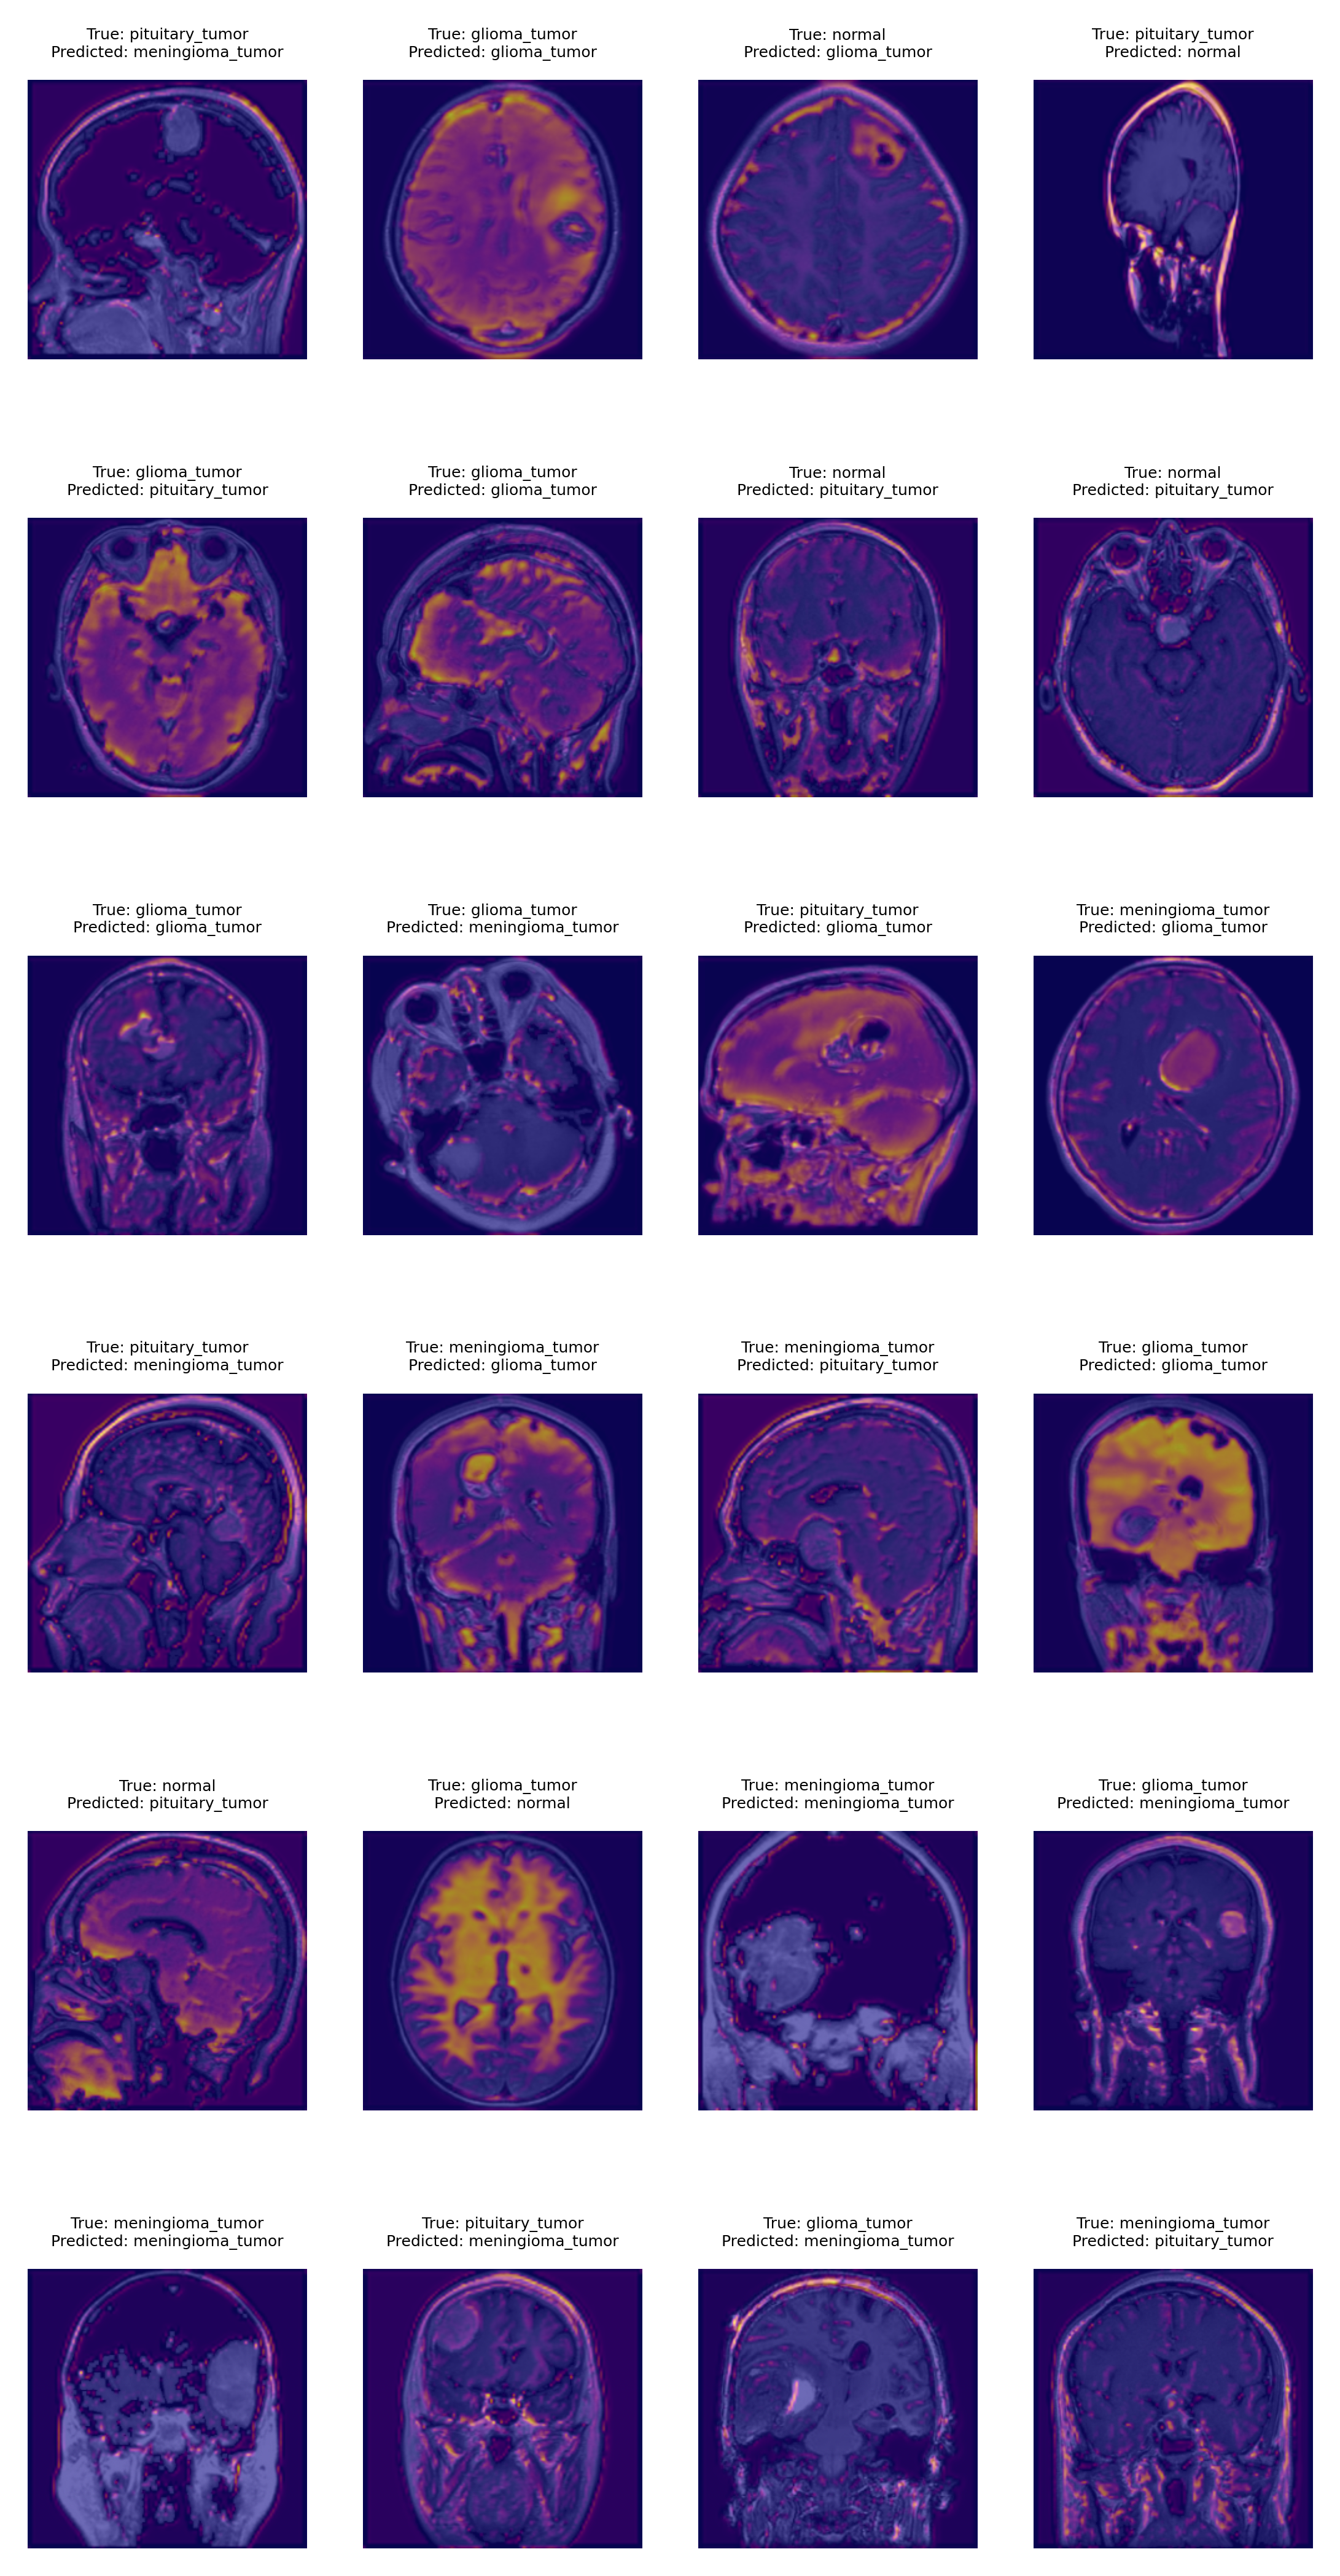

In [18]:
# GradCAM
LAYER_NAME = 'conv2d_3'
grad_model = tf.keras.models.Model([best_model.inputs], [best_model.get_layer(LAYER_NAME).output,
                                                    best_model.output])

# Remove last layer's activation
best_model.layers[-1].activation = None

plt.figure(figsize=(6, 12), dpi=450)

# Generate a list of random indices
random_indices = random.sample(range(test_x.shape[0]), 24)

for idx, ii in enumerate(random_indices):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        test_x[ii][np.newaxis, :, :, :], best_model, LAYER_NAME)

    heatmap_truncated = heatmap[0, :, :, 0]  # Keep only the first channel

    # Inverse transform to get the true label
    true_label_index = np.argmax(Y[ii])
    inverse_transformed_label = y_labelencoder.inverse_transform([
                                                                 true_label_index])
    actual_label = inverse_transformed_label[0]

    # Get the predicted label and confidence score
    img = test_x[ii][np.newaxis, :, :, :]
    pred = best_model.predict(img, verbose=0)
    predicted_label_index = np.argmax(pred)
    predicted_label = y_labelencoder.inverse_transform(
        [predicted_label_index])[0]
    confidence_score = np.max(pred)

    # Plot the original image, heatmap, and superimposed image
    plt.subplot(6, 4, idx + 1)
    plt.imshow(test_x[ii])
    plt.imshow(heatmap_truncated, alpha=0.6, cmap='plasma')

    # Display the label and confidence score as the subplot title
    plt.title(
        f"True: {actual_label}\nPredicted: {predicted_label}", fontsize=4)
    plt.axis("off")

plt.savefig('gradCAM.png')
plt.show()